## Inception V3 Model
### Installation and Import Checks

In [1]:
%pip install tensorflow==2.10
%pip install scikit-learn

%pip install matplotlib
%matplotlib inline
%pip install seaborn
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
# Machine Learning
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.metrics import Precision, Recall
from tabulate import tabulate
import pandas as pd

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. 

In [4]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded
y_output = to_categorical(y_output, num_classes=4)

# Resizes images to 299 x 299 for optimal size for InceptionV3
x_input_resized = np.array([tf.image.resize(image, (299, 299)).numpy() for image in x_input])

Split dataset into training and testing with a 80/20 ratio

In [5]:
# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Testing Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 299x299x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 299x299x3

Y Testing Data
Number of Rows: 384
Number of Classes: 4


### Defining the InceptionV3 Model

In [6]:
IMAGE_SIZE = [299, 299]

# Load the InceptionV3 model with weights pre-trained on ImageNet
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the existing weights
for layer in inception.layers:
    layer.trainable = False

# Add your own classification head to the model
x = GlobalAveragePooling2D()(inception.output)
x = Dense(256, activation='relu')(x)
x - Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

# Create a new model with the InceptionV3 base and your classification head
model = Model(inputs=inception.input, outputs=output)

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

# Define callbacks for best model saving to ./model_checkpoints
checkpoint_inceptionv3 = ModelCheckpoint('model_checkpoints/inceptionv3_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Display the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Train Model

In [8]:
history = model.fit(
    x_input_train, y_output_train,
    steps_per_epoch=None,
    epochs=30,
    validation_data=(x_input_test, y_output_test),
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.001), checkpoint_inceptionv3],
    use_multiprocessing=False,
    shuffle=True
)


Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 0.8140 - accuracy: 0.6764 - precision: 0.7344 - recall: 0.5996
Epoch 1: val_loss improved from inf to 0.54234, saving model to model_checkpoints\inceptionv3_brain_tumor.keras
48/48 [==============================] - 6s 84ms/step - loss: 0.8140 - accuracy: 0.6764 - precision: 0.7344 - recall: 0.5996 - val_loss: 0.5423 - val_accuracy: 0.7786 - val_precision: 0.7978 - val_recall: 0.7396 - lr: 0.0010
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8561 - precision: 0.8853 - recall: 0.8190
Epoch 2: val_loss did not improve from 0.54234
48/48 [==============================] - 3s 63ms/step - loss: 0.3845 - accuracy: 0.8561 - precision: 0.8853 - recall: 0.8190 - val_loss: 0.5654 - val_accuracy: 0.7943 - val_precision: 0.8115 - val_recall: 0.7734 - lr: 0.0010
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8919 - precision: 0.9074 - recall: 0.867

### Evaluation using Model Performance & Classification Metrics
Overall model Performance to be Plotted using Training/Validation over Epoches
* Loss 
* Accuracy
* Precision
* Recall

These model performance will be further drilled down in the confusion matrix and the classification report, where we will observe numbers for
* True Positive
* True Negatives
* False Positives
* False Negatives

In [9]:
def plot_model_performance(history, title):
    """Plot training and validation loss, accuracy, precision, and recall, and print metrics in a table format."""
    epochs = range(1, len(history.history['loss']) + 1)
    data = {
        'Epoch': epochs,
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss'],
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy'],
        'Training Precision': history.history['precision'],
        'Validation Precision': history.history['val_precision'],
        'Training Recall': history.history['recall'],
        'Validation Recall': history.history['val_recall']
    }
    df = pd.DataFrame(data)
    
    # Print the metrics in a table format using tabulate
    print(tabulate(df, headers='keys', tablefmt='pretty'))
    
    plt.figure(figsize=(10, 20))  # Adjust the figure size for better visibility

    # Plot loss
    plt.subplot(4, 1, 1)  # 4 rows, 1 column, first subplot
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(4, 1, 2)  # 4 rows, 1 column, second subplot
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    # Plot precision
    plt.subplot(4, 1, 3)  # 4 rows, 1 column, third subplot
    plt.plot(epochs, history.history['precision'], label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.ylim(0, 1)  # Fix the precision scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    # Plot recall
    plt.subplot(4, 1, 4)  # 4 rows, 1 column, fourth subplot
    plt.plot(epochs, history.history['recall'], label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.ylim(0, 1)  # Fix the recall scale from 0 to 1
    plt.yticks([i / 10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()

def plot_confusion_matrix(model):
    """Evaluate a trained model on test data and display the confusion matrix and classification report."""
    # Class labels
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # Predict the labels for the test data
    predictions = model.predict(x_input_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_output_test, axis=1)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print the classification report using tabulate
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("Classification Report:")
    print(tabulate(report_df, headers='keys', tablefmt='pretty'))

#### Simple & Classification Metrics for Model InceptionV3

+----+-------+-----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
|    | Epoch |     Training Loss     |   Validation Loss   | Training Accuracy  | Validation Accuracy | Training Precision | Validation Precision |  Training Recall   | Validation Recall  |
+----+-------+-----------------------+---------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
| 0  |  1.0  |  0.8139908313751221   | 0.5423423051834106  | 0.6764323115348816 | 0.7786458134651184  | 0.7344497442245483 |  0.7977527976036072  |    0.599609375     | 0.7395833134651184 |
| 1  |  2.0  |  0.3844585120677948   | 0.5654013156890869  | 0.8561198115348816 | 0.7942708134651184  | 0.8852920532226562 |  0.811475396156311   | 0.8190104365348816 |     0.7734375      |
| 2  |  3.0  |  0.2933114469051361   | 0.458632111

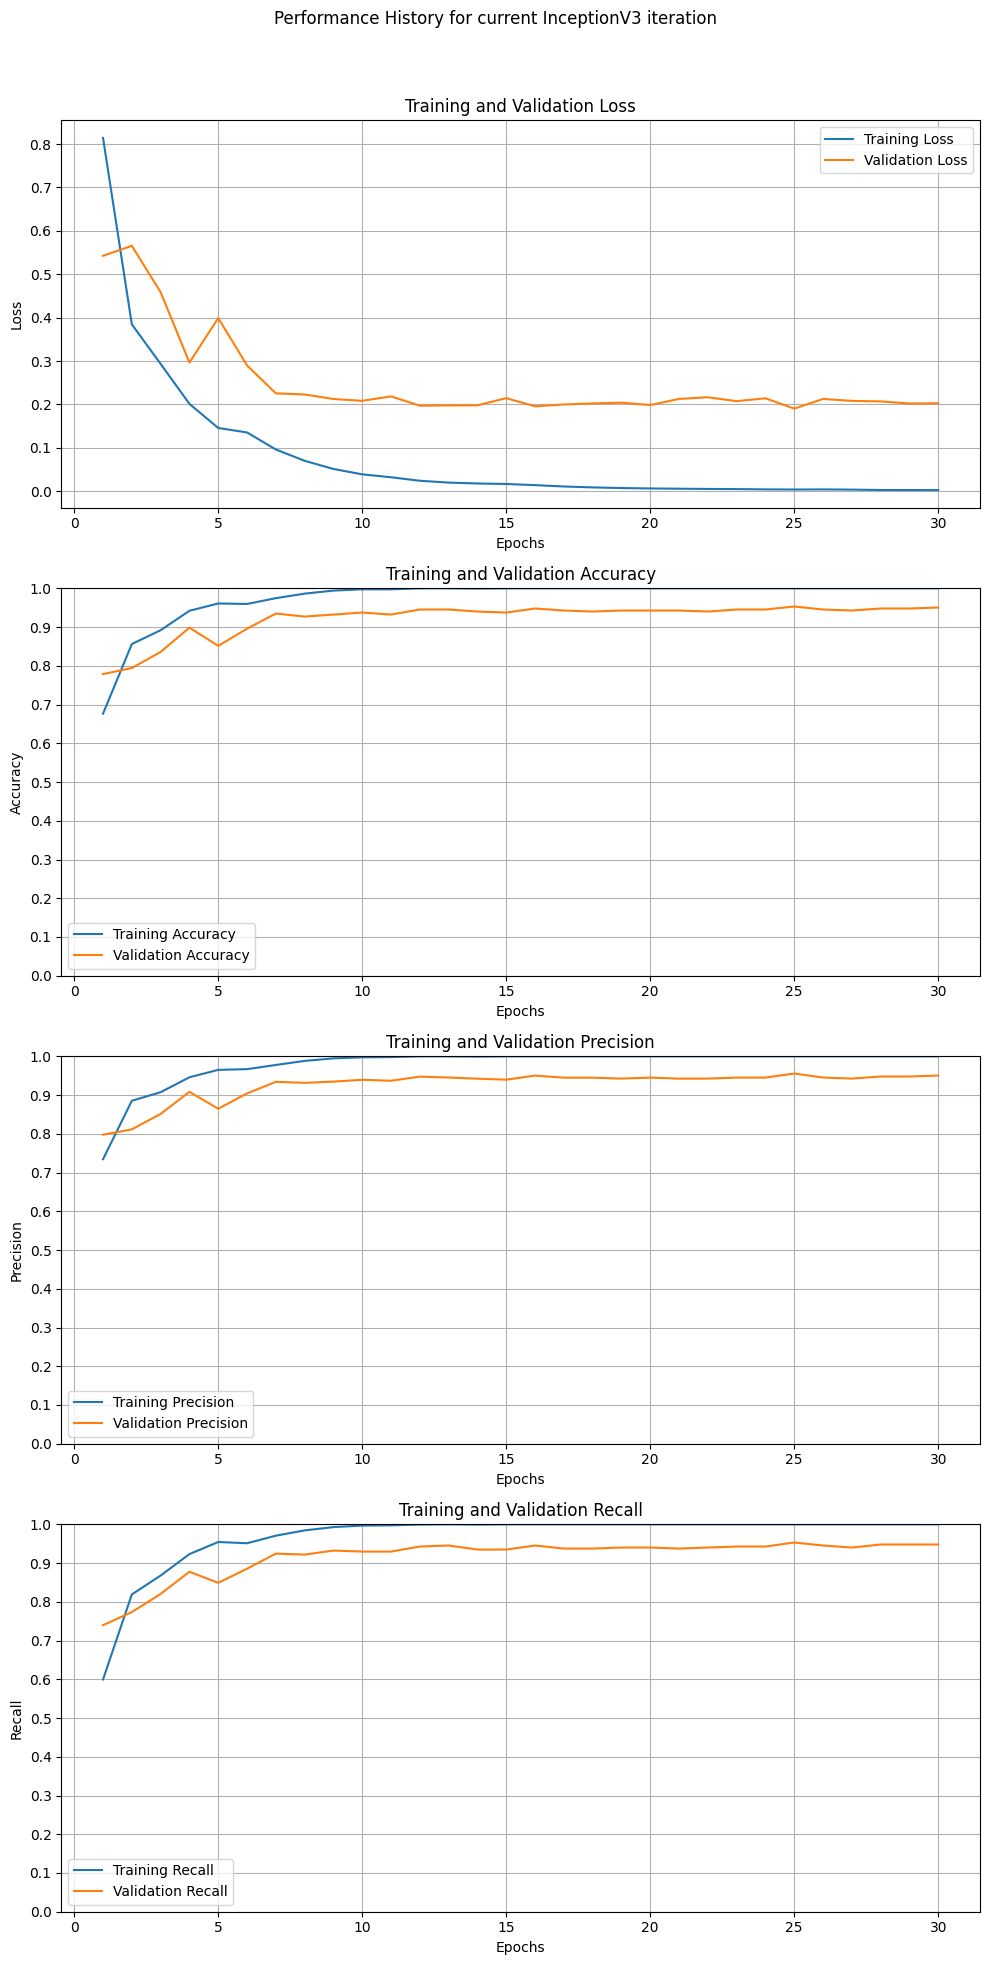

12/12 [==============================] - 1s 48ms/step


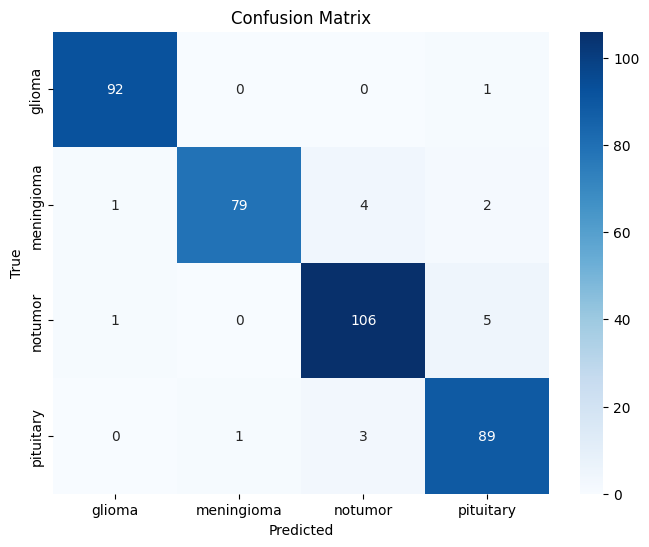

Classification Report:
+--------------+--------------------+--------------------+--------------------+----------+
|              |     precision      |       recall       |      f1-score      | support  |
+--------------+--------------------+--------------------+--------------------+----------+
|    glioma    | 0.9787234042553191 | 0.989247311827957  | 0.983957219251337  |   93.0   |
|  meningioma  |       0.9875       | 0.9186046511627907 | 0.9518072289156626 |   86.0   |
|   notumor    | 0.9380530973451328 | 0.9464285714285714 | 0.9422222222222222 |  112.0   |
|  pituitary   | 0.9175257731958762 | 0.956989247311828  | 0.9368421052631579 |   93.0   |
|   accuracy   |      0.953125      |      0.953125      |      0.953125      | 0.953125 |
|  macro avg   | 0.9554505686990821 | 0.9528174454327867 | 0.953707193913095  |  384.0   |
| weighted avg | 0.9540055218896252 |      0.953125      | 0.9531735618632394 |  384.0   |
+--------------+--------------------+--------------------+---------

In [13]:
plot_model_performance(history, "Performance History for current InceptionV3 iteration")
best_inceptionv3_model = load_model('model_checkpoints/inceptionv3_brain_tumor_model.keras')
plot_confusion_matrix(best_inceptionv3_model)